In [1]:
from pylab import * 
%matplotlib inline 

from IPython.display import Image

In [2]:
caffe_root = '/server-home1/egbert/caffe/examples'

In [3]:
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

In [4]:
import os

## 1) The Network 

The small size of the network is due to memory limitations. The network consists of two convolutional layers, two pooling layers, and one fully connected softmax layer. 

### tiny_net_1 

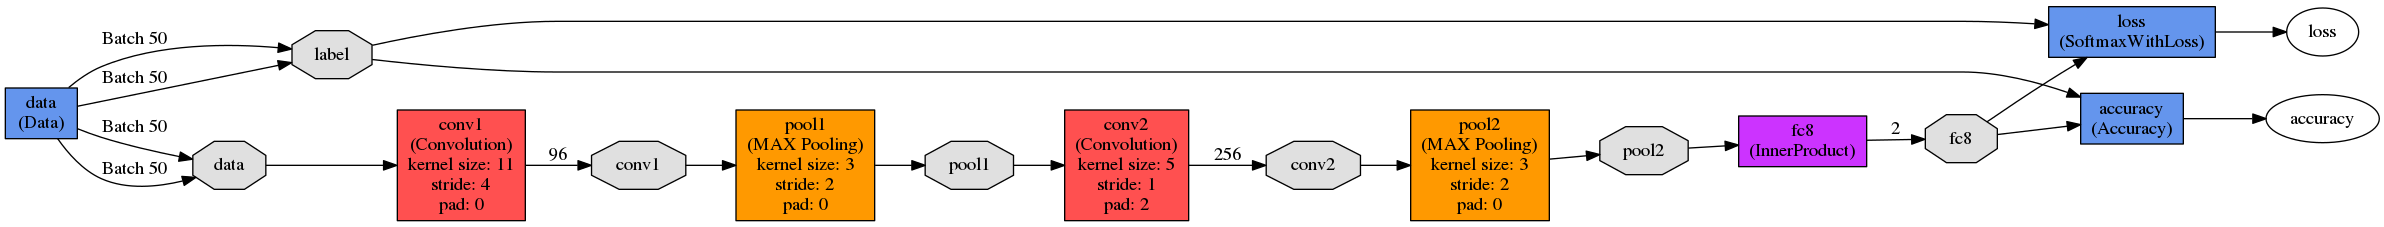

In [5]:
Image('tiny_net_1.png')

#### Option 1) Import net 

In [7]:
!cat train_tiny_net.prototxt

name: "AlexNet"
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  data_param {
    source: "AID604_train_lmdb"
    batch_size: 50
    backend: LMDB
  }
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 96
    kernel_size: 11
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 256
    pad: 2
    kernel_size: 5
    group: 2
    weight_filler {
      type: "gaussian"
  

In [ ]:
net = caffe.Net('train_tiny_net.prototxt', caffe.TRAIN)

#### Option 2) Build net using pycaffe  

In [8]:
from caffe import layers as L, params as P

def small_net_1(lmdb, batch_size):
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             #transform_param=dict(scale=1./255), ntop=2) #WHAT DOES SCALING THE IMAGES DO?
    
    n.conv1 = L.Convolution(n.data,
                            param(lr_mult=1, decay_mult=1),
                            param(lr_mult=2, decay_mult=0),
                            convolution_param(num_output=96, kernel_size=11,
                                              weight_filler=dict(type='gaussian', std=0.01),
                                              bias_filler(type='constant', value=0))
                            )
                            
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    n.conv2 = L.Convolution(n.pool1,
                            param(lr_mult=1, decay_mult=1),
                            param(lr_mult=2, decay_mult=0),
                            convolution_param(num_output=256, pad=2, kernel_size=5, group=2 
                                              weight_filler=dict(type='gaussian', std=0.01),
                                              bias_filler(type='constant', value=0.1))
                            )
    
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
                            
    n.relu1 = L.ReLU(n.pool2, lrn_param(local_size=5, alpha=0.0001, beta=0.75)
    
    n.fc1 =   L.InnerProduct(n.pool2, 
                             param(lr_mult=1, decay_mult=0), 
                             param(lr_mult=2, decay_mult=0),
                             
                             inner_product_param(num_output=50 ,
                                                 weight_filler(type='gaussian', std=0.01),
                                                 bias_filler(type='constant', value=0))
                            )
    
    n.score = L.InnerProduct(n.fc1, num_output=2, weight_filler=dict(type='gaussian'))
    
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('small_net_auto_train.prototxt', 'w') as f:
    f.write(str(small_net_1('AID604_train_lmdb', 50)))
    
with open('small_net__auto_test.prototxt', 'w') as f:
    f.write(str(small_net_1('AID604_test_lmdb', 50)))

SyntaxError: invalid syntax (<ipython-input-8-5d38b7ba0c7f>, line 17)

#### As option 1 was successful, we will use that net to continue


## 2) The Solver 

In [9]:
!cat tiny_net_1_solver.prototxt

net: "train_val_tiny_net.prototxt"
test_iter: 100
test_interval: 100
base_lr: 0.01
lr_policy: "step"
gamma: 0.1
stepsize: 300
display: 20
max_iter: 500
momentum: 0.9
weight_decay: 0.0005
snapshot: 10000
snapshot_prefix: "/server-home1/egbert/caffe/examples/imagenet/AID604"
solver_mode: GPU


## 3) Loading and Checking the Solver

In [ ]:
caffe.set_device(0)
caffe.set_mode_gpu()

## load the solver and create the train and test nets
solver = None
#solver = caffe.SGDSolver('tiny_net_1_solver.prototxt')
solver = caffe.get_solver('tiny_net_1_solver.prototxt')

## 4) Testing the Net

In [ ]:
solver.net.forward()
print("done!")

*no output to the last lines*